# Tabular Methods in Reinforcement Learning

In [2]:
import gymnasium as gym
from gymnasium.spaces.discrete import Discrete
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm
import imageio as iio
import pandas as pd

## Setup

### Global config

In [3]:
'''Global configs'''
# plot configs
n_plot_step=10

# environment
cw_env = gym.make("CliffWalking-v0", render_mode='rgb_array')

fl_env_deter = gym.make("FrozenLake-v1", is_slippery=False, render_mode='rgb_array')
fl_env_slippery = gym.make("FrozenLake-v1", is_slippery=True, render_mode='rgb_array')

taxi_env = gym.make("Taxi-v3", render_mode='rgb_array')

### Environment Setup

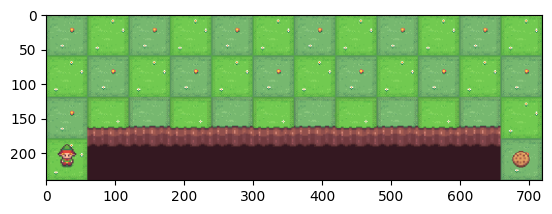

In [4]:
'''Make environment
- render_mode
    - 'human': open a live window (not interactive)
    - 'rgb_array': display an rgb image, can be rendered using plt.imshow(env.render())
'''
def render_frame(env, figsize=None):
    frame = env.render()
    figure, axis = plt.subplots(1, figsize = figsize)
    axis.imshow(frame)

# try rendering with Cliff-Walking environment
cw_env.reset()
render_frame(cw_env)

In [5]:
'''
- Make a wrapper class for environments to add reset_random() method that makes them reset from random states from state space
- These environments can be use for algorithms that need an exploring start
'''
from gymnasium.envs.toy_text.taxi import TaxiEnv

class TaxiESEnv(TaxiEnv):
    def __init__(self, render_mode: str | None = None):
        super().__init__(render_mode)

    def reset_random(self, seed = None):
        super().reset(seed=seed)
        self.s = np.random.randint(self.observation_space.n)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

Let's inspecting the state space and action space of the Cliff Walking environment!

<img src="images/cliff_walking/cw_dynamic.png" width=700, height=250>

In [6]:
print(f"_____STUDY THE ENVIRONMENT_____")
n_states = cw_env.observation_space.n
print(f"Total number of observations: {n_states}")
print(f"Sample an observation from the observation space: {cw_env.observation_space.sample()}")
n_actions = cw_env.action_space.n
print(f"Total number of actions: {n_actions}")
print(f"Sample an action from the action space: {cw_env.action_space.sample()}")

_____STUDY THE ENVIRONMENT_____
Total number of observations: 48
Sample an observation from the observation space: 42
Total number of actions: 4
Sample an action from the action space: 0


- We can retrieve the dynamic of the environment, which takes the form (probabiliy, next_state, reward, terminated).
- Take an example with the Frozen Lake environment, the following line of code prints out the dynamic of state 1, action 1 (move right)

In [7]:
print(fl_env_slippery.P[1][2])

[(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False)]


- As we can see, by choosing to move to the right at state 1, the agent actually moves to the right, left, or down, each with probability of 1/3

<img src="images/frozen_lake/fl_dynamic.png" width=300, height=300>

### Utils

#### Algorithm helpers

In [8]:
def calc_n_states_actions (env):
    '''
    Return the number of states, actions of a specific environment
    '''
    if (isinstance(env.observation_space, Discrete)):
        return env.observation_space.n, env.action_space.n
    else:
        n_states = 1
        for dim in env.observation_space:
            n_states *= dim.n
        n_actions = env.action_space.n
        return n_states, n_actions        

In [9]:
def greedy_policy (qtable, state):
    '''
    From current q-table, return a greedy action
    '''
    actions = np.argwhere(np.array(qtable[state, :]) == np.max(qtable[state, :]))
    return np.random.choice(actions.flatten())

In [10]:
def epsilon_greedy_policy (env, qtable, state, epsilon=0.1):
    '''
    From current q-table, return a greedy action with probability 1-epsilon, 
    or a random action from action space with probability epsilon
    '''
    n_states, n_actions = calc_n_states_actions(env)
    if (np.random.rand() > epsilon):
        action = greedy_policy(qtable, state)
        prob = 1 - epsilon + epsilon / n_actions
    else:
        action = env.action_space.sample()
        prob = epsilon / n_actions
    return action, prob

In [11]:
def get_greedy_policy_prob (env, qtable, state, action, epsilon):
    '''Get state-action probability of an epsi'''
    n_states, n_actions = calc_n_states_actions(env)
    best_action = np.argmax(qtable[state])
    if (action in (np.argwhere(qtable[state] == qtable[state][best_action])).flatten()):
        prob = 1 - epsilon + epsilon / n_actions
    else:
        prob = epsilon / n_actions
    return prob

In [12]:
def init_qtable (env):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    return np.zeros((n_states, n_actions))

def init_vtable (env):
    return np.zeros(env.observation_space.n)

In [13]:
def init_policy (env, zero_init=True):
    '''
    Used in Dynamic Programming algo where we only have a v-table.
    In other algos, although a policy is also needed, we can instead generate and update
    actions via the q-table, using the above "greedy_policy" and "epsilon_greedy_policy" functions
    '''
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    if zero_init:    
        return np.zeros((n_states, n_actions))
    else:
        return np.random.randn(n_states, n_actions)
    
def init_deterministic_policy(env):
    '''
    Instead of returning a distribution of actions for each state,
    this policy only returns the greediest action.
    '''
    policy = np.zeros(env.observation_space.n)
    return policy

In [14]:
def init_returns_table(env):
    '''
    Used in MC to store returns of state-action pairs for later averaging
    '''
    returns_table = [[[] for _ in range(env.action_space.n)] for _ in range(env.observation_space.n)]
    return returns_table

#### Visualization

In [15]:
def make_gif (env, qtable, greedy=True, out_dir='q-learning.gif', fps=1):
    '''
    Conduct a (greedy) policy according to the input q-table and make a gif
    '''
    n_max_frame = 200
    frames = []
    rewards = []
    state, info = env.reset()
    # print(state)
    first_frame = env.render()
    frames.append(first_frame)
    n_steps = 0
    while True:
        if greedy:
            action = greedy_policy(qtable, state)
        else:
            action, prob = epsilon_greedy_policy(env, qtable, state)
        next_state, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        state = next_state
        frame = env.render()
        frames.append(frame)
        if (n_steps > n_max_frame):
            break
        if terminated or truncated:
            frames.append(frame) 
            break
        n_steps += 1
    iio.mimsave(out_dir, [np.array(frame) for frame in frames], 'GIF')
    return frames[-1]

In [16]:
def visualize_qtable(env, qtable, policy, map_height, map_width, last_frame, vtable=None):
    directions = []
    action_arrow_mapping = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    if (vtable == None):
        vtable = np.argmax(qtable, axis=1).reshape(map_height, map_width)
    for state in range(env.observation_space.n):
        directions.append(action_arrow_mapping[np.argmax(policy[state])])
        # directions.append(np.argmax(policy[state]))
    directions = np.array(directions, dtype=str).reshape(map_height, map_width)

    figure, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(last_frame)
    axes[0].axis("off")
    axes[0].set_title("Last frame")

    sns.heatmap(vtable.reshape(map_height, map_width), 
                ax= axes[1],
                annot=directions, 
                fmt='',
                annot_kws={"fontsize": "xx-large"},)

In [17]:
def plot_rewards_steps(env_list, episodes_list, rewards_list, steps_list):      # rewards and steps are numpy 1d arrays
    '''
    Inputs:
        - env_list: (n_env,)
        - rewards_list: (n_env, n_eps)
        - steps_list: (n_env, n_eps)
    Each environment has 1 reward list, 1 step list
    To see which environment is easier for the algorithm to converge
    '''
    final_df = pd.DataFrame()
    for idx, env_id in enumerate(env_list):
        print(f"\033[1m Start running in {env_id}\033[0m")
        # print(np.array(episodes_list[idx]).shape)
        # print(np.array(rewards_list[idx]).shape)
        episodes = np.array(episodes_list[idx]).flatten()[None]
        rewards = np.array(rewards_list[idx]).flatten()[None]        # (1, d)
        steps = np.array(steps_list[idx]).flatten()[None]

        rewards_steps = np.concatenate([episodes.T, rewards.T, steps.T], axis=1)
        environment_df = pd.DataFrame(data=rewards_steps, columns=["Episode", "Accumulated Reward", "Steps until terminated"])

        environment_df["Environment"] = np.repeat(env_id, environment_df.shape[0])

        final_df = pd.concat([final_df, environment_df])
        # print(final_if.shape)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(data=final_df, x="Episode", y="Accumulated Reward", hue="Environment", ax=axes[0])
    sns.lineplot(data=final_df, x="Episode", y="Steps until terminated", hue= "Environment", ax=axes[1])

## Tabular Reinforcement Learning algorithms

### Dynamic Programming

In [18]:
def policy_evaluation(env, policy, threshold=0.01, gamma=0.9):
    vtable = init_vtable()
    delta = 0
    while True:
        for state in range(env.observation_space.n):
            old_value = vtable[state]
            new_value = 0
            for action in range(env.action_space.n):
                action_value = 0
                p_state_action = env.P[state][action]
                for possibility in p_state_action:
                    prob, new_state, reward, _ = possibility    # possbility = p(s'|s, a)
                    action_value += prob * (reward + gamma*vtable[new_state])
                new_value += policy[state, action] * action_value
            delta = max(delta, np.abs(new_value - old_value))
        if (delta < threshold): break
    return vtable

In [19]:
def policy_improvement(env, vtable, gamma=0.9):
    '''Here we assume that our policy is deterministic'''
    policy = init_policy(env)
    for state in range(env.observation_space.n):
        action_values = []
        for action in range(env.action_space.n):
            action_value = 0
            p_state_action = env.P[state][action]
            for possibility in p_state_action:
                prob, new_state, reward, _ = possibility
                action_value += prob * (reward + gamma*vtable[new_state])
            action_values.append(action_value)
        best_action = np.argmax(np.array(action_values))
        policy[state][best_action] = 1
    return policy

In [20]:
def policy_iteration(env, threshold=0.01, gamma=0.9):
    arb_policy = init_policy(env)
    arb_policy[:][0] = 1
    policy = arb_policy
    vtable = init_vtable(env)
    while True:
        old_vtable = vtable
        vtable = policy_evaluation(env, policy, gamma)
        policy = policy_improvement(env, vtable)
        delta_vtable = np.sum(np.abs(old_vtable - vtable))
        if (delta_vtable < threshold): break
    return vtable, policy

In [21]:
def value_iteration (env, threshold=1e-5, gamma=0.9):
    vtable = init_vtable(env)
    while True:
        delta = 0
        for state in range(env.observation_space.n):
            old_state_value = vtable[state]
            state_action_values = []
            for action in range(env.action_space.n):
                p_state_action = env.P[state][action]
                state_action_value = 0
                for possibility in p_state_action:
                    prob, next_state, reward, done = possibility
                    state_action_value += prob * (reward + gamma*vtable[next_state])
                state_action_values.append(state_action_value)
            new_state_value = np.max(np.array(state_action_values))
            vtable[state] = new_state_value
            new_delta = np.abs(new_state_value - old_state_value)
            delta = np.maximum(delta, new_delta)
        if delta < threshold: break
    print(f"Finish calculating value table!")
    policy = init_policy(env)
    for state in range(env.observation_space.n):
        state_action_values = []
        for action in range(env.action_space.n):
            p_state_action = env.P[state][action]
            state_action_value = 0
            for possibility in p_state_action:
                prob, next_state, reward, done = possibility
                state_action_value += prob * (reward + gamma*vtable[next_state])
            state_action_values.append(state_action_value)
        best_action = np.argmax(state_action_values)
        policy[state][best_action] = 1
    return vtable, policy   

### Monte Carlo

In [22]:
def MC_exploring_start(env: gym.Env, n_episodes: int, gamma: float = 0.9, n_max_steps=1e5):
    '''
    - The policy is deterministic
    '''
    qtable = init_qtable(env.observation_space.n, env.action_space.n)
    cancel_episode = False
    for episode in tqdm(range(n_episodes)):
        rewards = []
        state_action_pairs = []
        visited_state_mask = np.zeros((500))
        state, info = env.reset_random()                            # init state randomly
        start = True
        n_steps = 0
        while True:
            n_steps += 1
            if (start):
                action = np.random.randint(0, env.action_space.n)   # init action randomly
                start = False
            else:
                action = greedy_policy(qtable, state)
            state_action_pairs.append((state, action))
            new_state, reward, terminated, truncated, info = env.step(action)
            if visited_state_mask[state] == 1:
                rewards.append((reward, False))
            else:
                rewards.append((reward, True))
                visited_state_mask[state] = 1
            if terminated: break
            if n_steps > n_max_steps:
                cancel_episode = True
                break
            state = new_state
        if cancel_episode:
            cancel_episode = False
            continue
        returns = []                                                # init return table used to store returns of every state-action pair
        for i in range(env.observation_space.n):
            returns.append([[] for _ in range(env.action_space.n)])
        return_val = 0  
        for i in range(len(rewards) - 1, -1, -1):
            reward, first_visit = rewards[i]
            state, action = state_action_pairs[i]
            return_val = gamma*return_val + reward
            if first_visit:
                returns[state][action].append(return_val)
                qtable[state][action] = np.mean(returns[state][action])
    return qtable

In [23]:
def on_policy_epsilon_soft_MC(env: gym.Env, n_episodes: int = int(1e3), epsilon=0.1, gamma=0.9, n_max_steps=10000):
    '''
    - This algo is used to predict value of every state in the state space, given a policy
    '''
    qtable = init_qtable(env)
    returns = init_returns_table(env)

    for i in tqdm(range(n_episodes)):
        state, info = env.reset()
        rewards = []
        visited_state_mask = np.zeros(env.observation_space.n)
        state_action_pairs = []
        n_steps = 0
        cancel_episode = False
        while True:
            action, prob = epsilon_greedy_policy(env, qtable, state)
            state_action_pairs.append((state, action))
            state, reward, terminated, truncated, info = env.step(action)
            if (visited_state_mask[state] == 0):
                rewards.append((reward, True))
            else:
                rewards.append((reward, False))
            if terminated: 
                break
            if n_steps > n_max_steps:
                cancel_episode = True
                break
            n_steps += 1
        if cancel_episode == True:
            cancel_episode = False
            continue
        return_val = 0
        for i in range(len(rewards)-1, -1, -1):
            reward, first_visit = rewards[i]
            state, action = state_action_pairs[i]
            return_val = gamma*return_val + reward
            if first_visit:
                returns[state][action].append(return_val)
                qtable[state][action] = np.mean(returns[state][action])
    return qtable
                

In [24]:
def off_policy_MC (env, n_episodes=int(1e5), gamma=0.9, epsilon=0.1):
    '''
    - Behavior policy is an epsilon-greedy policy
    - Target policy is a greedy policy
    '''
    n_states = env.observation_space.n
    qtable = init_qtable(env)
    for i in tqdm(range(n_episodes)):
        G = 0.
        C = 0.
        W = 1.
        state, _ = env.reset()
        rewards = []
        state_action_prob_tuples = []
        while True:
            action, prob = epsilon_greedy_policy(env=env, qtable=qtable, state=state, epsilon=epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state_action_prob_tuples.append((state, action, prob))
            rewards.append(reward)
            if terminated or truncated:
                break
            state = next_state
        for t in range(len(rewards)-1, -1, -1):
            state, action, prob = state_action_prob_tuples[t]
            G = gamma*G + rewards[t]
            C += W
            if (W / C == np.nan): break
            qtable[state][action] += W / C * (G - qtable[state][action])
            if (action != greedy_policy(qtable, state)): break
            W = W*1./prob
    return qtable

### Temporal Difference (TD) Learning

#### SARSA

In [25]:
def SARSA(env, n_episodes: int = int(1e3), gamma=0.9, epsilon=1e-2, lr: float = 1e-3):
    qtable = init_qtable(env)
    for episode in tqdm(range(n_episodes)):
        state, _ = env.reset()
        action, _ = epsilon_greedy_policy(env, qtable, state, epsilon)
        while True:
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_action, _ = epsilon_greedy_policy(env, qtable, new_state, epsilon)
            qtable[state][action] += lr*(reward + gamma*qtable[new_state][new_action] - qtable[state][action])
            if terminated:
                break
            state = new_state
            action = new_action
    return qtable

#### Q-Learning

In [26]:
def q_learning (env, n_episodes=int(1e3), epsilon=0.1, lr=0.1, gamma=0.9, n_plot_steps=100):
    step = n_episodes // n_plot_steps
    qtable = init_qtable(env)
    metadata = {}

    plot_episodes = []
    plot_rewards = []
    plot_steps = []

    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        while True:
            action, _ = epsilon_greedy_policy(env, qtable, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)

            # update qtable
            qtable[state, action] = qtable[state,action] + lr * (reward + gamma*np.max(qtable[new_state, :] - qtable[state, action]))

            state = new_state

            if (episode % step == 0): 
                plot_episodes.append(episode)
                plot_rewards.append(reward)
            if (terminated): break
    metadata['plot_episode'] = plot_episodes
    metadata['plot_reward'] = plot_rewards
    metadata['plot_steps'] = plot_steps
    return qtable, metadata

#### Double Q-learning

In [27]:
def double_q_learning(env, n_episodes: int = int(1e3), gamma=0.9, epsilon=1e-1, lr=1e-2):
    qtable1 = init_qtable(env)
    qtable2 = init_qtable(env)
    for episode in tqdm(range(n_episodes)):
        state, _ = env.reset()
        while True:
            action, _ = epsilon_greedy_policy(env, qtable1+qtable2, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            if (np.random.rand() > 0.5):
                qtable1[state][action] += lr * (reward + gamma * qtable2[new_state][np.argmax(qtable1[new_state])] - qtable1[state][action])
            else:
                qtable2[state][action] += lr * (reward + gamma * qtable1[new_state][np.argmax(qtable2[new_state])] - qtable2[state][action])
            if terminated:
                break
            state = new_state
    return qtable1 + qtable2

### N-step Boostrapping

#### N-step SARSA

In [28]:
def n_step_SARSA (env, n_episodes: int = int(1e3), lr=1e-2, n: int = 5, gamma = 0.9, epsilon=1e-1):
    qtable = init_qtable(env)
    for episode in tqdm(range(n_episodes)):
        rewards = []
        state_action_pairs = []
        state, _ = env.reset()
        action, _ = epsilon_greedy_policy(env, qtable, state, epsilon)
        state_action_pairs.append((state, action))
        t = 0
        terminated_step = np.inf
        while True:
            if (t < terminated_step):
                state, reward, terminated, truncated, _ = env.step(action)
                rewards.append(reward)
                if terminated:
                    terminated_step = t + 1
                action, _ = epsilon_greedy_policy(env, qtable, state, epsilon)
                state_action_pairs.append((state, action))
            tau = t - n + 1
            if (tau >= 0):
                G = 0
                state_tau, action_tau = state_action_pairs[tau]
                for i in np.arange(tau+1, np.minimum(tau+n, terminated_step)+1, 1):               # the last index is discarded
                    G += gamma ** (i - tau - 1) * rewards[int(i)-1]
                if (tau + n < terminated_step): 
                    state_tau_n, action_tau_n = state_action_pairs[tau+n]
                    G += gamma ** n * qtable[state_tau_n][action_tau_n]
                qtable[state_tau][action_tau] += lr * (G - qtable[state_tau][action_tau])
            t += 1 
            if (tau == terminated_step - 1): break
    return qtable

#### N-step off-policy learning

In [29]:
def n_step_off_policy (env, n_episodes: int = int(1e3), lr=1e-2, n: int = 5, gamma = 0.9, b_epsilon=0.3, pi_deterministic=False, pi_epsilon=1e-1):
    if pi_deterministic: pi_epsilon = 0
    qtable = init_qtable(env)
    for episode in tqdm(range(n_episodes)):
        rewards = []
        state_action_prob_tuple = []
        state, _ = env.reset()
        action, prob = epsilon_greedy_policy(env, qtable, state, b_epsilon)
        state_action_prob_tuple.append((state, action, prob))
        t = 0
        terminated_step = np.inf
        while True:
            if (t < terminated_step):
                state, reward, terminated, truncated, _ = env.step(action)
                rewards.append(reward)
                if terminated:
                    terminated_step = t + 1
                action, prob = epsilon_greedy_policy(env, qtable, state, b_epsilon)
                state_action_prob_tuple.append((state, action, prob))
            tau = t - n + 1
            if (tau >= 0):
                G = 0
                p = 1
                for i in np.arange(tau+1, np.minimum(tau+n, terminated_step)+1, 1):
                    state_i, action_i, b_prob_i = state_action_prob_tuple[int(i)]
                    pi_prob_i = get_greedy_policy_prob(env, qtable, state_i, action_i, epsilon=pi_epsilon)
                    G += gamma ** (i - tau - 1) * rewards[int(i)-1]
                    if i == terminated_step: continue
                    else: p *= pi_prob_i / b_prob_i
                if (tau + n < terminated_step): 
                    state_tau_n, action_tau_n, prob_tau_n = state_action_prob_tuple[tau+n]
                    G += gamma ** n * qtable[state_tau_n][action_tau_n]
                state_tau, action_tau, prob_tau = state_action_prob_tuple[tau]
                qtable[state_tau][action_tau] += lr * p * (G - qtable[state_tau][action_tau])
                if (p == 0): break
            t += 1 
            if (tau == terminated_step - 1): break
    return qtable

#### N-step Tree-backup

In [30]:
def get_greedy_policy_dist(env, qtable, state, epsilon):
    n_states, n_actions = calc_n_states_actions(env)
    dist = [epsilon / n_actions for action in range(n_actions)]
    dist[np.argmax(qtable[state])] = 1 - epsilon + epsilon / n_actions
    return np.array(dist)

In [31]:
def n_step_tree_backup (env, n_episodes = int(1e5), n: int = 5, lr: float = 1e-2, gamma: float = 0.9, epsilon: float = 0.2, plot_step=100):
    metadata = {"episodes": [], "rewards": [], "steps": []}
    all_accum_rewards = []
    qtable = init_qtable(env)
    for episode in tqdm(range(n_episodes)):
        state_action_pairs = []
        rewards = []
        state, _ = env.reset()
        action, prob = epsilon_greedy_policy(env, qtable, state, epsilon)
        state_action_pairs.append((state, action))
        terminated_state = np.inf
        t = 0
        while True:
            if (t < terminated_state):
                state, reward, terminated, truncated, _ = env.step(action)
                rewards.append(reward)
                if terminated == True:
                    terminated_state = t + 1
                else:
                    action, _ = epsilon_greedy_policy(env, qtable, state, epsilon)
                    state_action_pairs.append((state, action))
            tau = t + 1 - n
            if tau >= 0:
                G = 0
                if t + 1 >= terminated_state:
                    G = rewards[terminated_state - 1]     # reward at T
                else:
                    cur_state, cur_action = state_action_pairs[t+1]
                    cur_policy_dist = get_greedy_policy_dist(env, qtable, cur_state, epsilon)
                    G = rewards[t] + gamma*cur_policy_dist.dot(qtable[cur_state])
                for k in range (int(np.minimum(t, terminated_state - 1)),  tau-1, -1):
                    state_k, action_k = state_action_pairs[k]
                    reward_k = rewards[k-1]
                    policy_dist_k = get_greedy_policy_dist(env, qtable, state_k, epsilon)
                    G = reward_k + gamma*policy_dist_k.dot(qtable[state_k]) - gamma*policy_dist_k[action_k]*qtable[state_k][action_k] + gamma*policy_dist_k[action_k]*G
                state_tau, action_tau = state_action_pairs[tau]
                qtable[state_tau][action_tau] += lr * (G - qtable[state_tau, action_tau])
            if tau == terminated_state-1: break
            t += 1
        all_accum_rewards.append(np.sum(rewards))
        # if (episode % plot_step == 0):
        metadata["episodes"].append(episode)
        metadata["rewards"].append(np.sum(all_accum_rewards[-plot_step:]) / plot_step)
        metadata["steps"].append(terminated_state)
    return qtable, metadata

## Experiments

### Experiment setup

In [32]:
'''Global config'''
env_dict = {"Frozen Lake no slippery": fl_env_deter, "Frozen Lake slippery": fl_env_slippery, "Cliff Walking":cw_env, "Taxi": taxi_env}
n_episodes_list = [1000, 10000, 100000]
output_gif = True
beta_epsilon = 0.3
pi_epsilon = 0.1
lr = 0.01
gamma = 0.9
threshold = 1e-3    # DP algos
n = 5               # n-step bootstrapping algos
sns.set_theme()

In [33]:
def experiment (env_dict, algo, n_episodes, n_runs, output_gif, **kwargs):
    '''
    Outputs:
        - metadata: dict with keys "episodes", "rewards", "steps", their values are arrays
        - experimenting with tree-backup algo
    '''
    rewards_list_all = []   # (n_envs, n_runs, n_episodes)
    steps_list_all = []
    episodes_list_all = []
    for env_id, env in env_dict.items():
        print(f'\033[1m Training in {env_id}... \033[0m')
        qtable = init_qtable(env)
        metadata = {}
        rewards_list = []
        steps_list = []
        episodes_list = []
        for run in range(n_runs):
            if (algo == value_iteration or algo == policy_iteration):
                vtable, policy, metadata = algo(env=env, **kwargs)
                if output_gif:
                    make_gif(env=env, qtable=policy, greedy=True, out_dir=f"{algo.__name__}/{algo.__name__}_{env_id}.gif")
            else:
                # print(f'\033[1m Number of episodes: {n_episodes}\033[0m')
                qtable, metadata = algo(env=env, n_episodes=n_episodes, **kwargs)
                # print(metadata)
                # plt.plot(metadata["episodes"], metadata["rewards"])
                # plt.show()
            if output_gif:
                make_gif(env=env, qtable=qtable, greedy=True, out_dir=f"{algo.__name__}_{env_id}.gif")
            rewards_list.append(metadata["rewards"])
            steps_list.append(metadata["steps"])
            episodes_list.append(metadata["episodes"])
        rewards_list_all.append(rewards_list)
        steps_list_all.append(steps_list)
        episodes_list_all.append(episodes_list)
    return episodes_list_all, rewards_list_all, steps_list_all

### Dynamic Programming

In [34]:
n_envs = 4
env_dict = {"Frozen Lake no slippery": fl_env_deter, "Frozen Lake slippery": fl_env_slippery, "Cliff Walking": cw_env, "Taxi": taxi_env}
episodes_list, rewards_list, steps_list = experiment(env_dict=env_dict, algo=n_step_tree_backup, n_episodes=1000, n_runs=5, output_gif=True, gamma=gamma)

 Training in Frozen Lake no slippery... 


100%|██████████| 1000/1000 [00:00<00:00, 1299.99it/s]


 Training in Frozen Lake slippery... 


100%|██████████| 1000/1000 [00:01<00:00, 776.20it/s]


 Training in Cliff Walking... 


100%|██████████| 1000/1000 [00:15<00:00, 63.62it/s]


 Training in Taxi... 


100%|██████████| 1000/1000 [01:30<00:00, 11.07it/s]


 Start running in Frozen Lake no slippery
 Start running in Frozen Lake slippery
 Start running in Cliff Walking
 Start running in Taxi


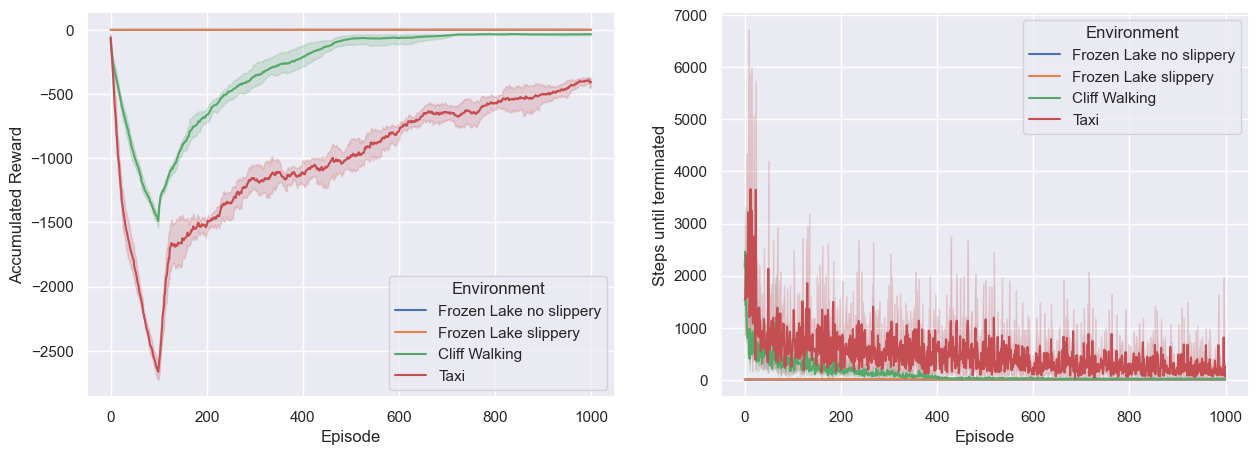

In [35]:
plot_rewards_steps(env_list=env_dict, episodes_list=episodes_list, rewards_list=rewards_list, steps_list=steps_list)

### Monte Carlo

### TD

### N-steps bootstrapping

## Inspection

In [36]:
vtable, policy = value_iteration(fl_env_slippery)
map_height = map_width = int(np.sqrt(fl_env_slippery.observation_space.n))
visualize_vtable(fl_env_slippery, vtable, policy, map_height, map_width)

Finish calculating value table!


NameError: name 'visualize_vtable' is not defined

Hmmm... You may notice that something's a little bit... off! Why do we want to go "left" in state 0 but not "right" or "down"? First, let's print out the value table:

In [ ]:
print(vtable)

[0.18039012 0.15469372 0.15343524 0.13250279 0.20890033 0.
 0.1764108  0.         0.27040866 0.37462244 0.40365378 0.
 0.         0.50896041 0.72366405 0.        ]


According to this value table, the value of state 4 is greater than that of state 1, which means that we should move "down" when we are in state 0. Let's next inspect the environment dynamic at state 0 when we respectively go "left", "down", "right" and "up"

In [ ]:
print(fl_env_slippery.P[0])

{0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}


We can observe that when we move "left", there's a 66% chance that we will end up in the same state, and 33% chance that we will end up in state 4 (which is equivalent to going "down" if our environment is not "slippery"). But when we move "right" or "down", there is an equal chance that we will end up in state 0, 1, and 4. And if you look closer to the value table, the value of state 0 is indeed, greater than that of state 1, which means that we'd rather stay in the same state than transfer to the state on the right! The policy now totally makes sense, right?

Just for the sake of sanity check, the environment's dynamic when it's deterministic (or not slippery) is either 1 or 0 for p(s'|s,a)

In [ ]:
print(fl_env_deter.P[0])

{0: [(1.0, 0, 0.0, False)], 1: [(1.0, 4, 0.0, False)], 2: [(1.0, 1, 0.0, False)], 3: [(1.0, 0, 0.0, False)]}


Q-learning, Cliff-Walking

We can notice a few things from this plot:
- Values from state 37 to 46 are 0, because these are terminal states.
- Values of the states on the right (11, 23, 35) are generally higher than values of the states on the left (0, 12, 24, 36) with respect to all actions.
- From state 25 to 34, values corresponding to the "move down" action are lower than values correspond to other actions
- When in state 36, "move right" is the least desirable action to take